In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from timeit import default_timer as timer
from scipy.optimize import minimize_scalar
from pyswarms.single.global_best import GlobalBestPSO

# Optimizers

In [3]:
def my_pso(objective, n_particles, bounds, inertia_wgt=1, cog_coef=1, soc_coef=1, 
        tol=1e-5, max_iter=100, full=False):
    # Vectorized implementation of particle swarm optimization

    # initialization
    positions = np.random.uniform(low=bounds[0], high=bounds[1], size=(n_particles,))
    losses = np.array(list(map(objective, positions))).flatten()
    nfev = n_particles  # number of objective evaluations
    best_known_pos = positions
    best_known_los = losses
    best_overall = np.argmin(best_known_los)  # index of best particle
    prev_best_los = best_known_los[best_overall]
    velocities = np.random.uniform(low=-abs(bounds[1] - bounds[0]), high=abs(bounds[1] - bounds[0]))
    
    itrctr = 0
    diff = np.inf  # solution improvement
    t0 = timer()
    while diff > tol and itrctr < max_iter: 
        rp = np.random.uniform(size=(n_particles,))
        rg = np.random.uniform(size=(n_particles,))

        # compute velocities and move
        velocities = inertia_wgt*velocities + cog_coef*rp*(best_known_pos - positions) + \
            soc_coef*rg*(np.repeat(positions[best_overall], n_particles) - positions)
        positions += velocities

        # impose boundary constraints (sinks) -- TODO reevaluate this decision
        positions = np.where(positions < bounds[0], bounds[0]*np.ones((n_particles,)), positions)
        positions = np.where(positions > bounds[1], bounds[1]*np.ones((n_particles,)), positions)

        # compute losses and best known losses and positions for particles
        losses = np.array(list(map(objective, positions))).flatten()
        nfev += n_particles
        best_known_pos = np.where(losses < best_known_los, positions, best_known_pos)
        best_known_los = np.minimum(losses, best_known_los)
        best_overall = np.argmin(best_known_los)

        # update termination thresholds
        diff = np.abs(prev_best_los - best_known_los[best_overall])
        prev_best_los = best_known_los[best_overall]
        itrctr += 1
    t1 = timer()
    
    if full:
        return {'min' : best_known_pos[best_overall], 'funcalls' : nfev, 'loss' : best_known_los[best_overall], 
                'wall' : t1 - t0, 'iters' : itrctr}
    else:
        return best_known_pos[best_overall]

In [4]:
def my_brent(objective, bounds, tol=1e-5, full=False):       
    t0 = timer() 
    rslts = minimize_scalar(objective, method='bounded', bounds=bounds, options={'xatol' : tol})
    t1 = timer()

    if full:
        return {'min' : rslts.x, 'funcalls' : rslts.nfev, 'losses' : rslts.fun, 'wall' : t1 - t0}
    else:
        return rslts.x

In [5]:
def my_golden(objective, bw_min, bw_max, tol=1e-5, max_iter=1000, full=False):
    # Adapts the implementation from PySAL for custom output here
    delta = 0.38197 # (sqrt(5) - 1)/2, function of phi
    a = bw_min; c = bw_max
    b = bw_min + delta * np.abs(bw_max - bw_min)
    d = bw_max - delta * np.abs(bw_max - bw_min)
    
    opt_score = np.inf
    diff = 1.0e9
    nfev = 0
    iters = 0
    output = []
    tracker = {}
    t0 = timer()
    while np.abs(diff) > tol and iters < max_iter and a != np.inf:
        iters += 1

        if b in tracker:
            loss_b = tracker[b]
        else:
            loss_b = objective(b)
            nfev += 1
            tracker[b] = loss_b

        if d in tracker:
            loss_d = tracker[d]
        else:
            loss_d = objective(d)
            nfev += 1
            tracker[d] = loss_d

        if loss_b <= loss_d:
            optval = b
            opt_score = loss_b
            c = d
            d = b
            b = a + delta * np.abs(c - a)

        else:
            optval = d
            opt_score = loss_d
            a = b
            b = d
            d = c - delta * np.abs(c - a)

        output.append((optval, opt_score))
        
        optval = np.round(optval, 2)
        if (optval, opt_score) not in output:
            output.append((optval, opt_score))
        
        diff = loss_b - loss_d
        score = opt_score
        
    
    if a == np.inf or bw_max == np.inf:
        score_ols = objective(np.inf)
        nfev += 1
        output.append((np.inf, score_ols))
            
        if score_ols <= opt_score:
            opt_score = score_ols
            optval = np.inf
        
    t1 = timer()

    candidates = [x[0] for x in output]
    losses = [x[1] for x in output]

    if full:
        return {'min' : optval, 'candidates' : candidates, 'funcalls' : nfev, 'losses' : losses, 'iters' : iters, 'wall' : t1 - t0}
    else:
        return optval

In [6]:
def my_grid(objective, bw_min, bw_max, num=None, pool=None, full=False):
    # Perform grid search
    if num is None: num = bw_max - bw_min + 1

    search_range = np.linspace(start=bw_min, stop=bw_max, num=num)
    
    if pool:
        t0 = timer()
        rslt = pool.map(objective, search_range)
        pool.close()
        pool.join()
        t1 = timer()
    else:
        t0 = timer()
        rslt = map(objective, search_range)
        t1 = timer()
    
    results = list(rslt)
    optval = search_range[np.argmin(results)]
    if full:
        return {'min' : optval, 'candidates' : list(search_range), 'losses' : results, 'iters' : bw_max - bw_min + 1, 
            'funcalls' : bw_max - bw_min + 1, 'wall' : t1 - t0}
    else:
        return optval

# Generate sample curves

In [7]:
# Bandwidth array
bws = np.linspace(start=2, stop=250, num=249)

In [8]:
def gen_henon_map(x, n_iter=100, a=1.76, b=0.1):
    xprev = x
    x2prev = np.zeros((x.shape))
    for _ in range(n_iter):
        x = a - xprev**2 - b*x2prev
        x2prev = xprev
        xprev = x
    return x

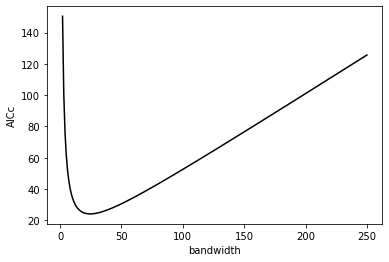

In [13]:
# arr = (bws**2 - bws + 600)/(2*bws) + 10*(gen_henon_map(bws)/gen_henon_map(bws).max())
plt.plot(bws, (bws**2 - bws + 600)/(2*bws), '-k')#+ 10*gen_henon_map(bws/1000))
plt.xlabel('bandwidth')
plt.ylabel('AICc')
plt.savefig('../../figures/baseline.png')
plt.show()

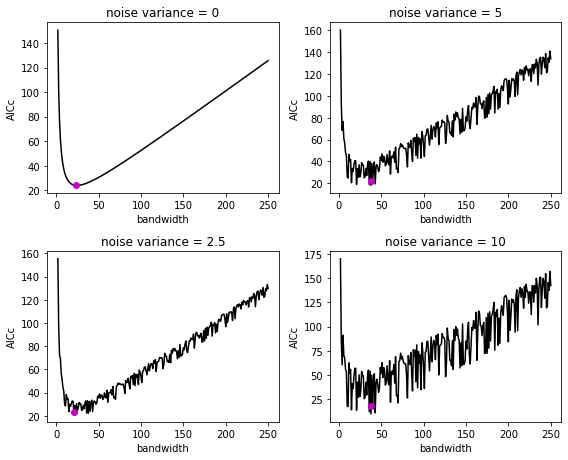

In [14]:
# Several checkmarks for varying noise levels. 
# kind of a weird way to do it but this ensures we're dealing with the same noise
# uses the Generalized Henon Map to create deterministic jitters

checkmark = lambda x, noiselvl : (x**2 - x + 600)/(2*x) + noiselvl*gen_henon_map(x/1000)

_, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6.5))
axes[0, 0].plot(bws, checkmark(bws, 0), '-k')
axes[0, 0].plot(bws[np.argmin(checkmark(bws, 0))], min(checkmark(bws, 0)), 'om')
axes[0, 0].set_title('noise variance = 0')
axes[0, 0].set_xlabel('bandwidth')
axes[0, 0].set_ylabel('AICc')

axes[1, 0].plot(bws, checkmark(bws, 5), '-k')
axes[1, 0].plot(bws[np.argmin(checkmark(bws, 5))], min(checkmark(bws, 2.5)), 'om')
axes[1, 0].set_title('noise variance = 2.5')
axes[1, 0].set_xlabel('bandwidth')
axes[1, 0].set_ylabel('AICc')

axes[0, 1].plot(bws, checkmark(bws, 10), '-k')
axes[0, 1].plot(bws[np.argmin(checkmark(bws, 10))], min(checkmark(bws, 5)), 'om')
axes[0, 1].set_title('noise variance = 5')
axes[0, 1].set_xlabel('bandwidth')
axes[0, 1].set_ylabel('AICc')

axes[1, 1].plot(bws, checkmark(bws, 20), '-k')
axes[1, 1].plot(bws[np.argmin(checkmark(bws, 20))], min(checkmark(bws, 10)), 'om')
axes[1, 1].set_title('noise variance = 10')
axes[1, 1].set_xlabel('bandwidth')
axes[1, 1].set_ylabel('AICc')

plt.tight_layout()
plt.savefig('../../figures/noisy-curves.png')
plt.show()

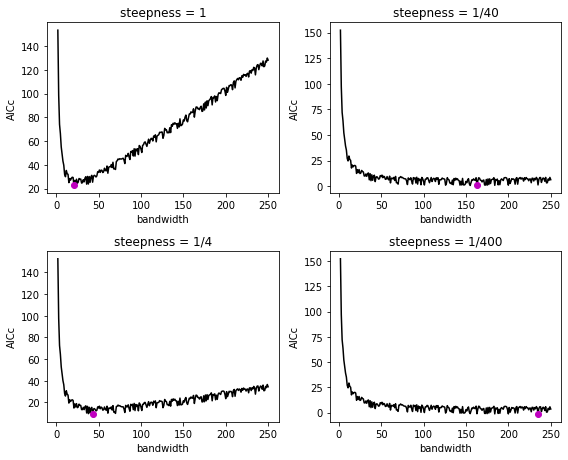

In [15]:
# Steep to flat curves for a modest noise level
steepnesses = [1, 1/4, 1/40, 1/400]
steepmark = lambda x, steepness : (steepness*x**2 - x + 600)/(2*x) + 3*gen_henon_map(x/1000)

_, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6.5))
axes[0, 0].plot(bws, steepmark(bws, 1), '-k')
axes[0, 0].plot(bws[np.argmin(steepmark(bws, 1))], min(steepmark(bws, 1)), 'om')
axes[0, 0].set_title('steepness = 1')
axes[0, 0].set_xlabel('bandwidth')
axes[0, 0].set_ylabel('AICc')

axes[1, 0].plot(bws, steepmark(bws, 1/4), '-k')
axes[1, 0].plot(bws[np.argmin(steepmark(bws, 1/4))], min(steepmark(bws, 1/4)), 'om')
axes[1, 0].set_title('steepness = 1/4')
axes[1, 0].set_xlabel('bandwidth')
axes[1, 0].set_ylabel('AICc')

axes[0, 1].plot(bws, steepmark(bws, 1/40), '-k')
axes[0, 1].plot(bws[np.argmin(steepmark(bws, 1/40))], min(steepmark(bws, 1/40)), 'om')
axes[0, 1].set_title('steepness = 1/40')
axes[0, 1].set_xlabel('bandwidth')
axes[0, 1].set_ylabel('AICc')

axes[1, 1].plot(bws, steepmark(bws, 1/400), '-k')
axes[1, 1].plot(bws[np.argmin(steepmark(bws, 1/400))], min(steepmark(bws, 1/400)), 'om')
axes[1, 1].set_title('steepness = 1/400')
axes[1, 1].set_xlabel('bandwidth')
axes[1, 1].set_ylabel('AICc')

plt.tight_layout()
plt.savefig('../../figures/steep-curves.png')
plt.show()

In [16]:
# Multiple min generating function for modest noise level
def mult_mins(x, avals=[1]):
    target = np.array([(x**2 - x + 600)/(2*x)])
    minfunc = lambda x : 0.0005*((x-120)/10)**8 + 5*((2*x - 120)/10) - 5

    for a in avals: 
        target = np.vstack((target, minfunc(x - a) + a/2))

    return target.min(axis=0) + 3*gen_henon_map(x/1000)

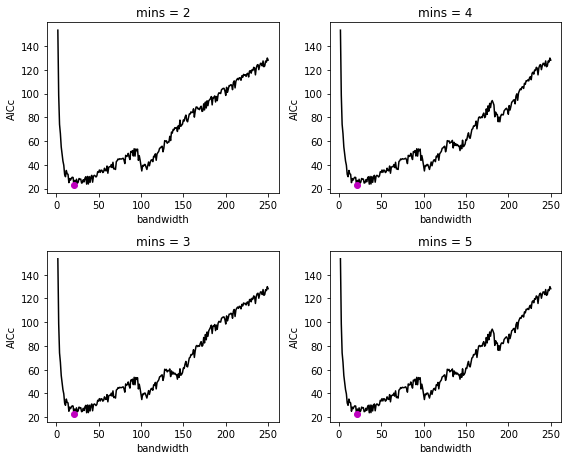

In [17]:
# Plots of multiple mins for modest noise leve
avals = [15, 50, 100, 200]

_, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6.5))
axes[0, 0].plot(bws, mult_mins(bws, avals=avals[:1]), '-k')
axes[0, 0].plot(bws[np.argmin(mult_mins(bws, avals=avals[:1]))], min(mult_mins(bws, avals=avals[:1])), 'om')
axes[0, 0].set_title('mins = 2')
axes[0, 0].set_xlabel('bandwidth')
axes[0, 0].set_ylabel('AICc')

axes[1, 0].plot(bws, mult_mins(bws, avals=avals[:2]), '-k')
axes[1, 0].plot(bws[np.argmin(mult_mins(bws, avals=avals[:2]))], min(mult_mins(bws, avals=avals[:2])), 'om')
axes[1, 0].set_title('mins = 3')
axes[1, 0].set_xlabel('bandwidth')
axes[1, 0].set_ylabel('AICc')

axes[0, 1].plot(bws, mult_mins(bws, avals=avals[:3]), '-k')
axes[0, 1].plot(bws[np.argmin(mult_mins(bws, avals=avals[:3]))], min(mult_mins(bws, avals=avals[:3])), 'om')
axes[0, 1].set_title('mins = 4')
axes[0, 1].set_xlabel('bandwidth')
axes[0, 1].set_ylabel('AICc')

axes[1, 1].plot(bws, mult_mins(bws, avals=avals[:4]), '-k')
axes[1, 1].plot(bws[np.argmin(mult_mins(bws, avals=avals[:4]))], min(mult_mins(bws, avals=avals[:4])), 'om')
axes[1, 1].set_title('mins = 5')
axes[1, 1].set_xlabel('bandwidth')
axes[1, 1].set_ylabel('AICc')

plt.tight_layout()
plt.savefig('../../figures/multiple-mins-curves.png')
plt.show()

# Test optimizers

In [49]:
# Steepmarks. Fix hyperparams before entering loop
bounds = (2, 1000)
max_iter = 1000
tol = 1e-10
steep_res = pd.DataFrame(index=['grid', 'golden', 'brent', 'pso'])
steepnesses = np.logspace(start=1/400, stop=1, num=50)
true_steep_min = lambda steeplvl : np.sqrt(600/steeplvl) # found from derivative

for steeplvl in steepnesses:
    obj = lambda x : steepmark(x, steeplvl)
    grid_steep_res = my_grid(obj, bw_min=bounds[0], bw_max=bounds[1], pool=None, full=True)
    brent_steep_res = my_brent(obj, bounds=bounds, tol=tol, full=True)
    golden_steep_res = my_golden(obj, bw_min=bounds[0], bw_max=bounds[1], tol=tol, max_iter=max_iter, full=True)
    pso_steep_res = my_pso(obj, n_particles=40, bounds=bounds, inertia_wgt=0.5, cog_coef=1, soc_coef=2, tol=tol, max_iter=max_iter, full=True)

    steep_res[f'wall_{steeplvl}'] = [grid_steep_res['wall'], golden_steep_res['wall'], brent_steep_res['wall'], pso_steep_res['wall']]
    steep_res[f'min_{steeplvl}'] = [grid_steep_res['min'], golden_steep_res['min'], brent_steep_res['min'], pso_steep_res['min']]
    steep_res[f'acc_{steeplvl}'] = abs(steep_res[f'min_{steeplvl}'] - true_steep_min(steeplvl))
    steep_res[f'funcalls_{steeplvl}'] = [grid_steep_res['funcalls'], golden_steep_res['funcalls'], brent_steep_res['funcalls'], pso_steep_res['funcalls']]
    steep_res[f'iters_{steeplvl}'] = [grid_steep_res['iters'], golden_steep_res['iters'], np.nan, pso_steep_res['iters']]

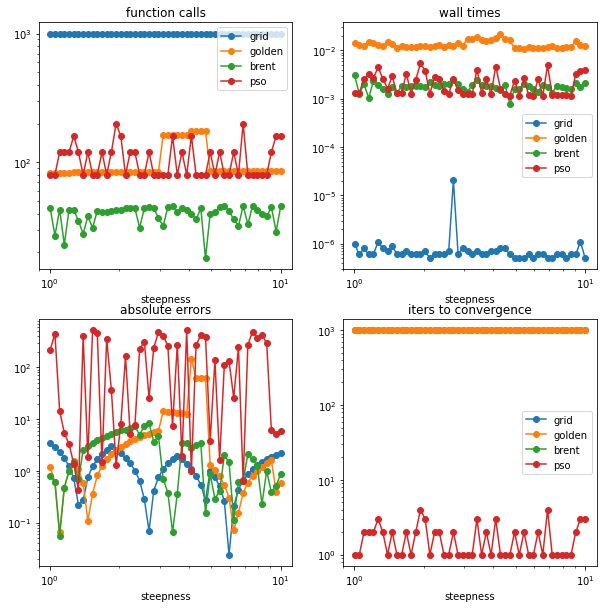

In [50]:
_, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 10))

steep_funcalls = steep_res[[f'funcalls_{x}' for x in steepnesses]].values.T
steep_accs = steep_res[[f'acc_{x}' for x in steepnesses]].values.T
steep_walls = steep_res[[f'wall_{x}' for x in steepnesses]].values.T
steep_iters = steep_res[[f'iters_{x}' for x in steepnesses]].values.T

axes[0, 0].loglog(steepnesses, steep_funcalls, '-o')
axes[0, 0].legend(steep_res.index.values)
axes[0, 0].set_title('function calls')
axes[0, 0].set_xlabel('steepness')

axes[1, 0].loglog(steepnesses, steep_accs, '-o')
axes[1, 0].set_title('absolute errors')
axes[1, 0].set_xlabel('steepness')

axes[0, 1].loglog(steepnesses, steep_walls, '-o')
axes[0, 1].legend(steep_res.index.values, loc='right')
axes[0, 1].set_title('wall times')
axes[0, 1].set_xlabel('steepness')

axes[1, 1].loglog(steepnesses, steep_iters, '-o')
axes[1, 1].legend(steep_res.index.values)
axes[1, 1].set_title('iters to convergence')
axes[1, 1].set_xlabel('steepness')

# plt.suptitle('Steepness results', fontsize=20)
plt.savefig('../../figures/steepness-res.png')
plt.show()

In [47]:
# Checkmarks with noise. Fix hyperparams before entering loop
noiselevels = np.linspace(start=0, stop=25, num=50)
# true_noise_mins = {0 : 24.495, 5 : 24.495, 10 : 24.495, 15 : 24.495, 20 : 24.495}
true_noise_mins = dict(zip(noiselevels, [np.argmin(checkmark(bws, noiselvl)) for noiselvl in noiselevels]))
bounds = (2, 1000)
max_iter = 1000
tol = 1e-10
noise_res = pd.DataFrame(index=['grid', 'golden', 'brent', 'pso'])

for noiselvl in noiselevels:
    obj = lambda x : checkmark(x, noiselvl)
    grid_noise_res = my_grid(obj, bw_min=bounds[0], bw_max=bounds[1], pool=None, full=True)
    brent_noise_res = my_brent(obj, bounds=bounds, tol=tol, full=True)
    golden_noise_res = my_golden(obj, bw_min=bounds[0], bw_max=bounds[1], tol=tol, max_iter=max_iter, full=True)
    pso_noise_res = my_pso(obj, n_particles=40, bounds=bounds, inertia_wgt=-0.16, cog_coef=1.89, soc_coef=2.12, tol=tol, max_iter=max_iter, full=True)

    noise_res[f'wall_{noiselvl}'] = [grid_noise_res['wall'], golden_noise_res['wall'], brent_noise_res['wall'], pso_noise_res['wall']]
    noise_res[f'min_{noiselvl}'] = [grid_noise_res['min'], golden_noise_res['min'], brent_noise_res['min'], pso_noise_res['min']]
    noise_res[f'acc_{noiselvl}'] = abs(noise_res[f'min_{noiselvl}'] - true_noise_mins[noiselvl])
    noise_res[f'funcalls_{noiselvl}'] = [grid_noise_res['funcalls'], golden_noise_res['funcalls'], brent_noise_res['funcalls'], pso_noise_res['funcalls']]
    noise_res[f'iters_{noiselvl}'] = [grid_noise_res['iters'], golden_noise_res['iters'], np.nan, pso_noise_res['iters']]

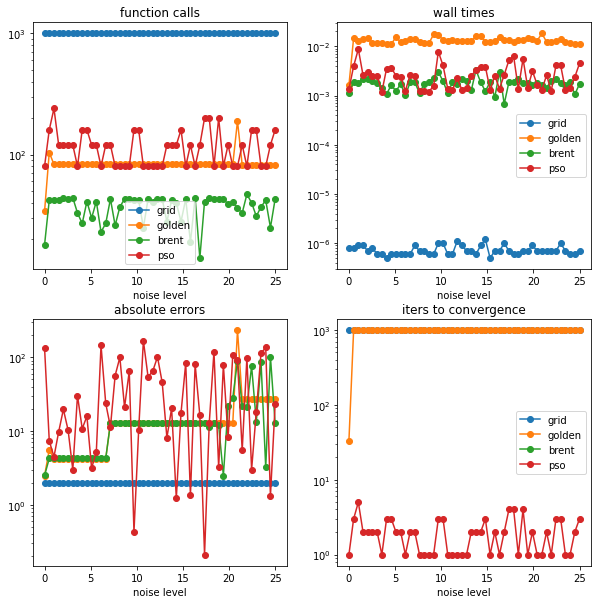

In [48]:
noise_funcalls = noise_res[[f'funcalls_{x}' for x in noiselevels]].values.T
noise_accs = noise_res[[f'acc_{x}' for x in noiselevels]].values.T
noise_walls = noise_res[[f'wall_{x}' for x in noiselevels]].values.T
noise_iters = noise_res[[f'iters_{x}' for x in noiselevels]].values.T

_, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 10))
axes[0, 0].semilogy(noiselevels, noise_funcalls, '-o')
axes[0, 0].legend(noise_res.index.values)
axes[0, 0].set_title('function calls')
axes[0, 0].set_xlabel('noise level')

axes[1, 0].semilogy(noiselevels, noise_accs, '-o')
axes[1, 0].set_title('absolute errors')
axes[1, 0].set_xlabel('noise level')

axes[0, 1].semilogy(noiselevels, noise_walls, '-o')
axes[0, 1].legend(noise_res.index.values)
axes[0, 1].set_title('wall times')
axes[0, 1].set_xlabel('noise level')

axes[1, 1].semilogy(noiselevels, noise_iters, '-o')
axes[1, 1].legend(noise_res.index.values)
axes[1, 1].set_title('iters to convergence')
axes[1, 1].set_xlabel('noise level')

# plt.suptitle('Noisy curve results', fontsize=20)
plt.savefig('../../figures/noisy-res.png')
plt.show()

In [45]:
# Multiple mins
avals = [15, 50, 100, 200, 300, 400, 450, 500]
n_mins = list(range(1, len(avals)+1))
true_multi_mins = dict(zip(n_mins, [np.argmin(mult_mins(bws, avals=avals[:i+1])) for i in range(len(avals))]))
bounds = (2, 1000)
max_iter = 1000
tol = 1e-10
multi_res = pd.DataFrame(index=['grid', 'golden', 'brent', 'pso'])

for i in n_mins:
    obj = lambda x : mult_mins(x, avals=avals[:i+1])
    grid_multi_res = my_grid(obj, bw_min=bounds[0], bw_max=bounds[1], pool=None, full=True)
    brent_multi_res = my_brent(obj, bounds=bounds, tol=tol, full=True)
    golden_multi_res = my_golden(obj, bw_min=bounds[0], bw_max=bounds[1], tol=tol, max_iter=max_iter, full=True)
    pso_multi_res = my_pso(obj, n_particles=40, bounds=bounds, inertia_wgt=1, cog_coef=1, soc_coef=1, tol=tol, max_iter=max_iter, full=True)

    multi_res[f'wall_{i}'] = [grid_multi_res['wall'], golden_multi_res['wall'], brent_multi_res['wall'], pso_multi_res['wall']]
    multi_res[f'min_{i}'] = [grid_multi_res['min'], golden_multi_res['min'], brent_multi_res['min'][0], pso_multi_res['min']]
    multi_res[f'acc_{i}'] = abs(multi_res[f'min_{i}'] - true_multi_mins[i])
    multi_res[f'funcalls_{i}'] = [grid_multi_res['funcalls'], golden_multi_res['funcalls'], brent_multi_res['funcalls'], pso_multi_res['funcalls']]
    multi_res[f'iters_{i}'] = [grid_multi_res['iters'], golden_multi_res['iters'], np.nan, pso_multi_res['iters']]

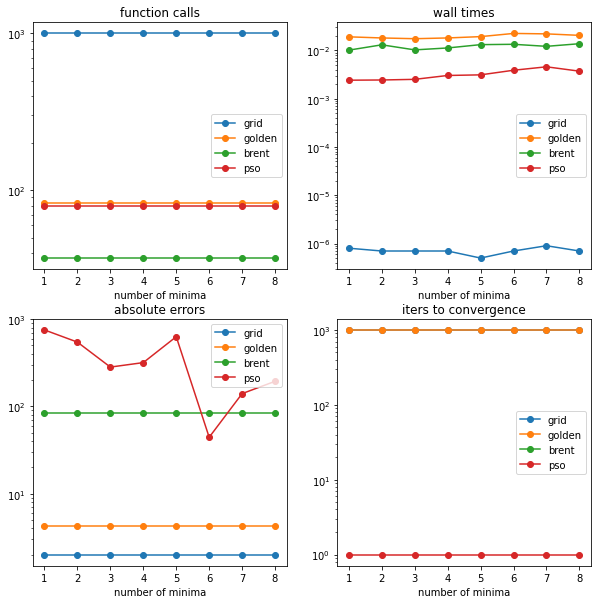

In [46]:
multi_funcalls = multi_res[[f'funcalls_{i}' for i in n_mins]].values.T
multi_accs = multi_res[[f'acc_{i}' for i in n_mins]].values.T
multi_walls = multi_res[[f'wall_{i}' for i in n_mins]].values.T
multi_iters = multi_res[[f'iters_{i}' for i in n_mins]].values.T

_, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 10))
axes[0, 0].semilogy(n_mins, multi_funcalls, '-o')
axes[0, 0].legend(multi_res.index.values)
axes[0, 0].set_title('function calls')
axes[0, 0].set_xlabel('number of minima')

axes[1, 0].semilogy(n_mins, multi_accs, '-o')
axes[1, 0].legend(multi_res.index.values)
axes[1, 0].set_title('absolute errors')
axes[1, 0].set_xlabel('number of minima')

axes[0, 1].semilogy(n_mins, multi_walls, '-o')
axes[0, 1].legend(multi_res.index.values)
axes[0, 1].set_title('wall times')
axes[0, 1].set_xlabel('number of minima')

axes[1, 1].semilogy(n_mins, multi_iters, '-o')
axes[1, 1].legend(multi_res.index.values)
axes[1, 1].set_title('iters to convergence')
axes[1, 1].set_xlabel('number of minima')

# plt.suptitle('Multiple minima results', fontsize=20)
plt.savefig('../../figures/multmins-res.png')
plt.show()